In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import cirq
import sympy
import numpy as np
import collections
import pandas as pd
import qsimcirq

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

from matplotlib.ticker import ScalarFormatter

from scipy.optimize import curve_fit


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_quantum as tfq

2022-06-08 08:50:22.033510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:50:22.040059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:50:22.041504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:50:22.201418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Load dataset

### -> Read files path

In [5]:
import os
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [6]:
# train
## data
proj_train_path = "../../juno_data/data/projections/reduced/train"
train_files     = os.listdir(proj_train_path)
train_proj   = [file for file in train_files if "npy" in file]
train_proj.sort(key=natural_keys)

## labels
target_train_path = "../../juno_data/data/real/train/targets"
train_target_files = os.listdir(target_train_path)
train_target       = [file for file in train_target_files if "targets" in file]
train_target.sort(key=natural_keys)
train_target = train_target[:20]

In [7]:
# test
energies = ['0', '0.1', '0.3', '0.6'] + [str(i) for i in range(1, 11)]

## data & labels
proj_test_path = "../../juno_data/data/projections/reduced/test"
target_test_path = "../../juno_data/data/real/test/targets"

test_proj_dict   = { e:None for e in energies}
test_target_dict = { e:None for e in energies}
for i, e in enumerate(energies):
    proj_files_path   = proj_test_path + "/e+_" + e
    target_files_path = target_test_path + "/e+_" + e
    
    proj_files   = os.listdir(proj_files_path)
    target_files = os.listdir(target_files_path)
    
    test_proj_dict[e]    = [file for file in proj_files if "npy" in file] 
    test_target_dict[e]  = [file for file in target_files if "targets" in file]
    
    test_proj_dict[e].sort(key=natural_keys)
    test_target_dict[e].sort(key=natural_keys)
    
    test_target_dict[e] = test_target_dict[e][:50]

### -> Load data in np.arrays

In [7]:
# train
## data
mat = np.empty(shape=(0, 57, 31, 2))

for file in train_proj:
    f   = np.load(proj_train_path + '/' + file, mmap_mode='r')
    mat = np.concatenate((mat, f), axis=0)
    
mat.shape

(100000, 57, 31, 2)

In [8]:
train_images = mat

In [9]:
del mat

In [10]:
train_labels = np.empty(shape = (0))
for i, file in enumerate(train_target):
    f = np.array(pd.read_csv(target_train_path + '/' + file)["edep"])
    train_labels = np.concatenate((train_labels, f), axis=0)

### -> Event display

In [11]:
# full event
full_mat = np.load("../../juno_data/data/projections/proj_raw_data_train_0.npz", mmap_mode='r')['arr_0']

In [14]:
full_mat[np.isnan(full_mat)]=0

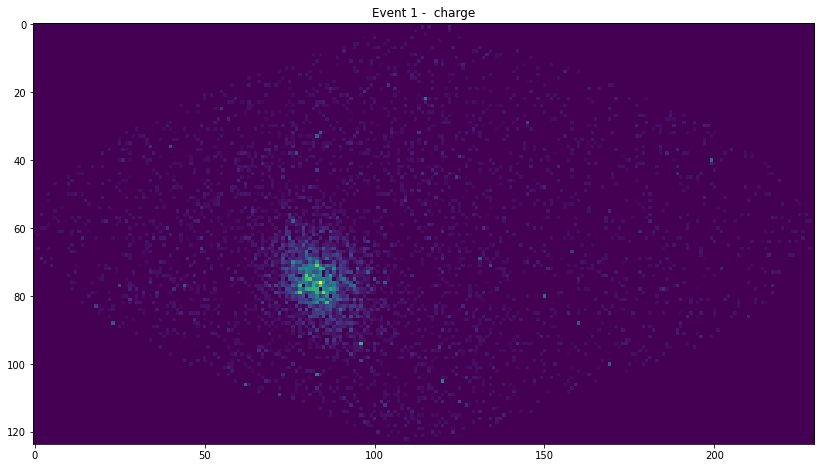

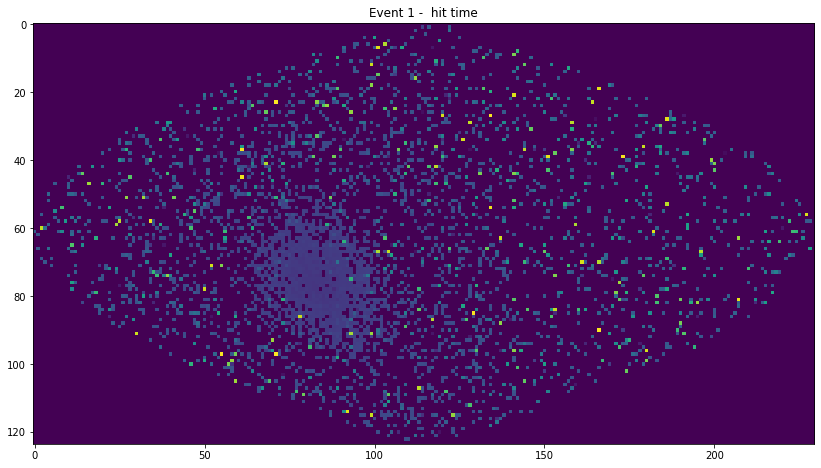

In [15]:
ev = 1

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  charge".format(ev))
plt.imshow(full_mat[ev,:,:,0].T)

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  hit time".format(ev))
plt.imshow(full_mat[ev,:,:,1].T)

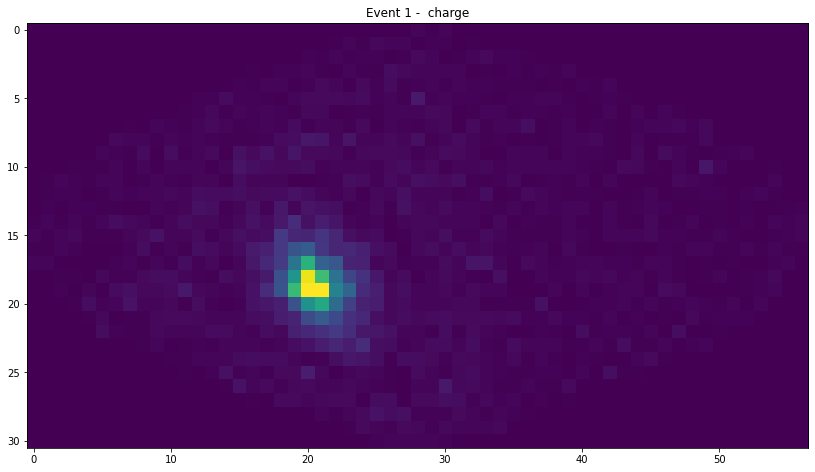

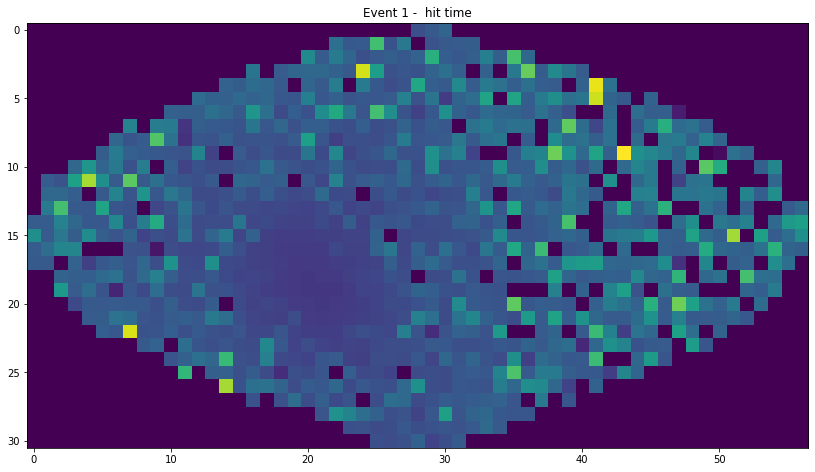

In [16]:
ev = 1

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  charge".format(ev))
plt.imshow(mat[ev,:,:,0].T)

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  hit time".format(ev))
plt.imshow(mat[ev,:,:,1].T)

## CNN model

In [11]:
fig_shape = (train_images.shape[1], train_images.shape[2])
channels  = train_images.shape[3]

In [12]:
def cnn_model_2(
    img_size = (57, 31),
    channels = 2
):
    cnn_model = models.Sequential(
        [
            layers.Conv2D(
                filters     = 32, 
                kernel_size = 3, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            # layers.BatchNormalization(),
            layers.Conv2D(
                filters     = 64, 
                kernel_size = 2, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            layers.Conv2D(
                filters     = 1, 
                kernel_size = 2, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            # layers.BatchNormalization(),
            # layers.MaxPool2D(pool_size=2, strides=2),
            layers.Flatten(),
            # layers.Dense(128, activation='relu'),
            # layers.Dropout(0.1),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.1),
            # layers.Dense(32, activation='relu'),
            # layers.Dropout(0.1),
            layers.Dense(128, activation='relu'),
            # layers.Dropout(0.1),
            # layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return cnn_model

In [13]:
cnn = cnn_model_2(
    img_size = fig_shape,
    channels = channels
)

2022-06-08 08:46:46.670593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:46:46.677650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:46:46.679050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 08:46:46.680965: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 15, 32)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 7, 64)         8256      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 3, 1)           257       
                                                                 
 flatten (Flatten)           (None, 21)                0         
                                                                 
 dense (Dense)               (None, 512)               11264     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [15]:
n_epochs   = 40
batch_size = 64

cnn_history = cnn.fit(
    train_images[:50000],
    train_labels[:50000],
    validation_split = 0.1,
    batch_size       = batch_size,
    epochs           = n_epochs, 
    verbose          = 2
)

2022-06-08 08:47:00.536882: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 606.65MiB (rounded to 636120064)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-08 08:47:00.536934: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-06-08 08:47:00.536946: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 23, Chunks in use: 23. 5.8KiB allocated for chunks. 5.8KiB in use in bin. 476B client-requested in use in bin.
2022-06-08 08:47:00.536953: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2022-06-08 08:47:00.536959: I tens

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

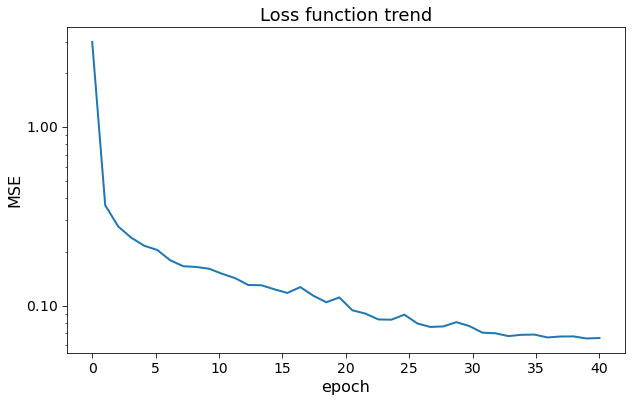

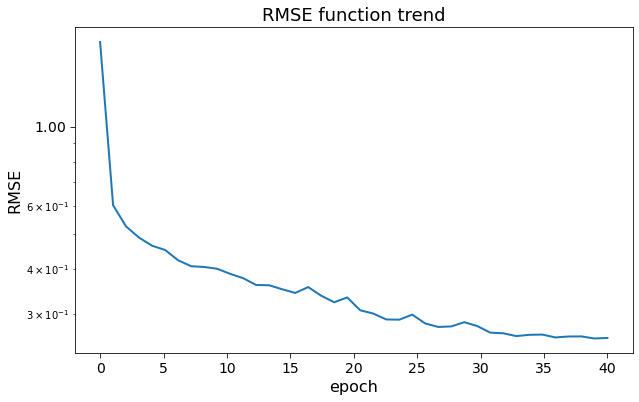

In [45]:
loss = cnn_history.history["loss"]
rmse = cnn_history.history["root_mean_squared_error"]
epochs = np.linspace(0, n_epochs, n_epochs)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, lw=2)

ax.set_title("Loss function trend", fontsize=18)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("MSE", fontsize=16)

ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)
# ax.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(epochs, rmse, lw=2)

ax.set_title("RMSE function trend", fontsize=18)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("RMSE", fontsize=16)

ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)
# ax.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))

plt.show()

## Prediction

In [46]:
#cnn.save('./models/cnn')

2022-06-08 08:00:31.993149: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/cnn/assets


In [11]:
cnn = tf.keras.models.load_model("./models/cnn/")

### -> Load dataset

In [8]:
# test
## data
test_images = {e:None for e in energies}

for e in energies:
    f = list()
    for file in test_proj_dict[e]:
        f.append(np.load(proj_test_path + "/e+_" + e + '/' + file, mmap_mode='r'))
    test_images[e] = np.concatenate(f, axis=0)
    del f

In [9]:
## labels
test_labels = {e:None for e in energies}
for e in energies:
    test_labels[e] = np.empty(shape = (0))
    for file in test_target_dict[e]:
        f = np.array(pd.read_csv(target_test_path + "/e+_" + e + '/' + file)["edep"])
        test_labels[e] = np.concatenate((test_labels[e], f), axis=0)

### -> Make predictions

In [12]:
edep_pred = {e:None for e in energies}

with tf.device("/CPU:0"):
    for e in energies:
        edep_pred[e] = cnn.predict(test_images[e])
        del test_images[e]

In [ ]:
for e in energies:
    test_labels[e] = test_labels[e].astype('float32')
    edep_pred[e] = edep_pred[e].astype('float32')

In [13]:
for e in energies:
    edep_pred[e] = np.reshape(edep_pred[e], (edep_pred[e].shape[0]))

In [14]:
res = {e:None for e in energies}

for e in energies:
    res[e] = (edep_pred[e]-test_labels[e])/test_labels[e]
    res[e] = res[e][np.abs(res[e] - res[e].mean()) < 3*res[e].std()]

### -> Gaussian fit

In [16]:
def gaus(x, a, mu, sigma):
    return a*np.exp( -(x-mu)**2 / (2*sigma**2) )

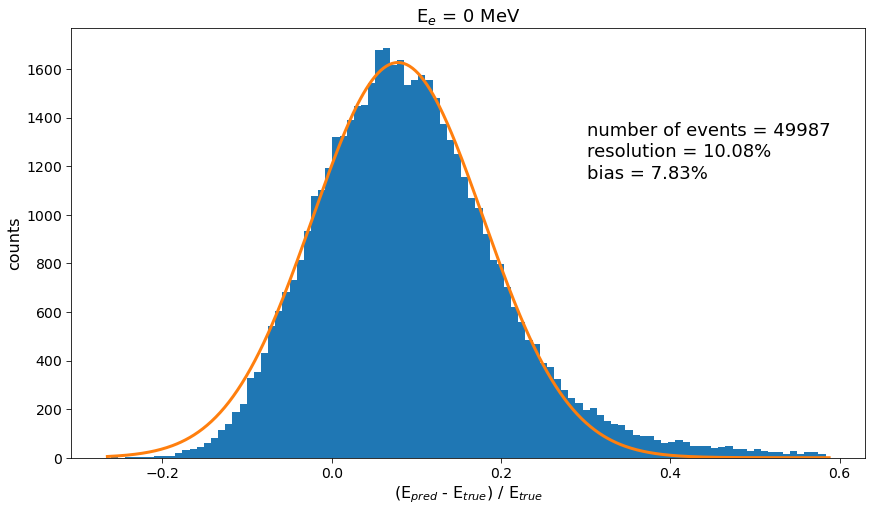

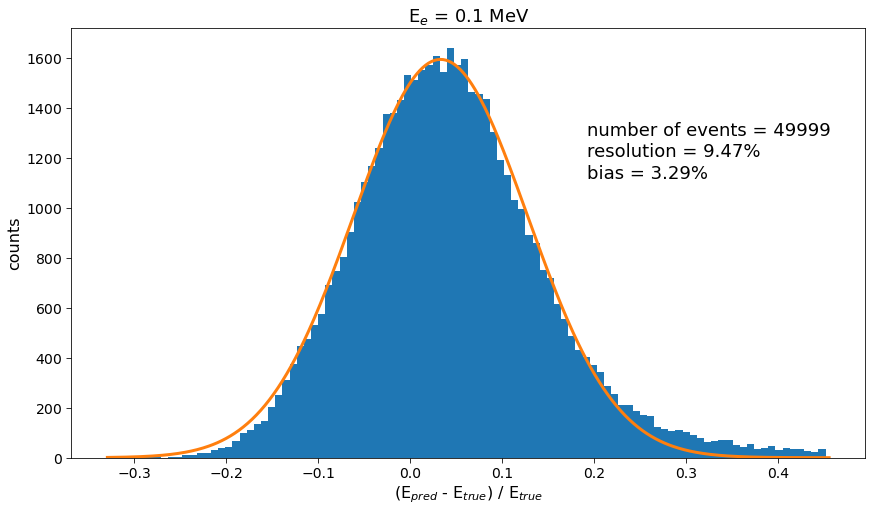

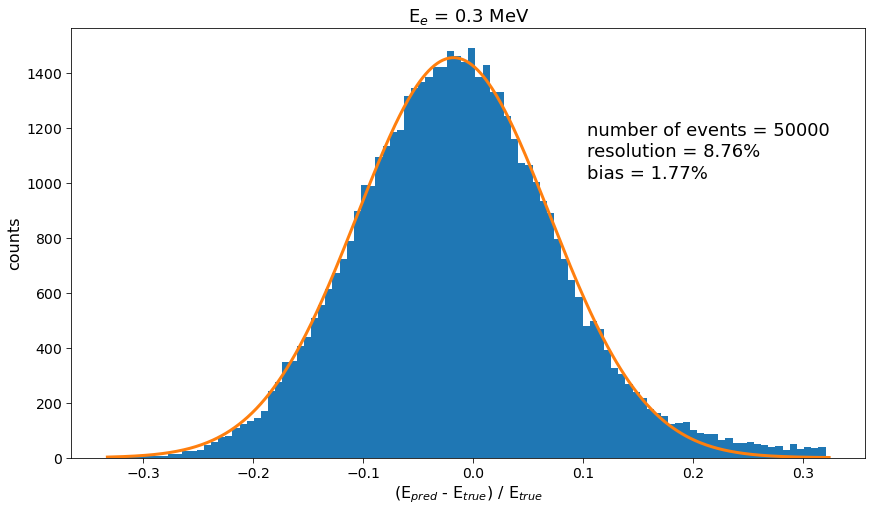

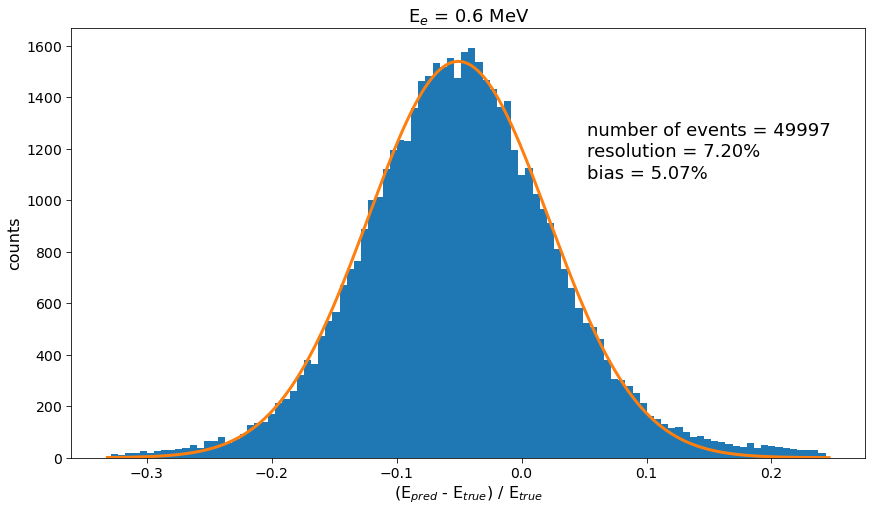

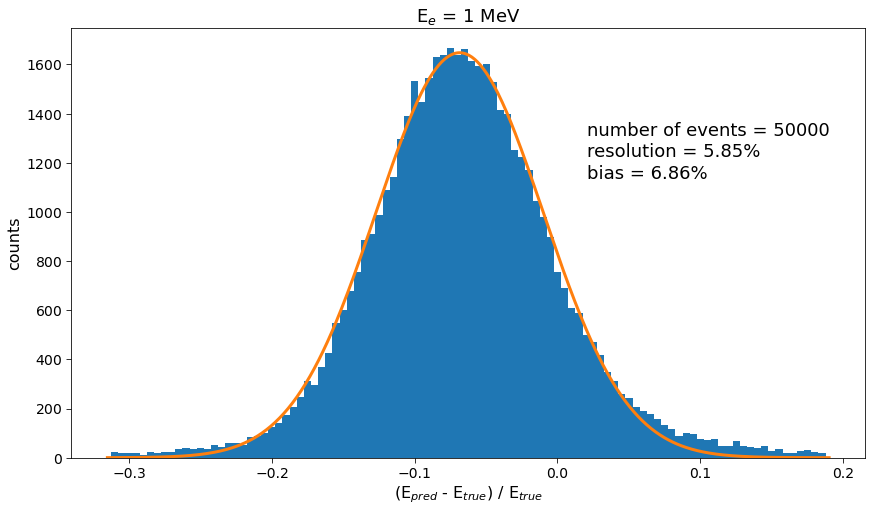

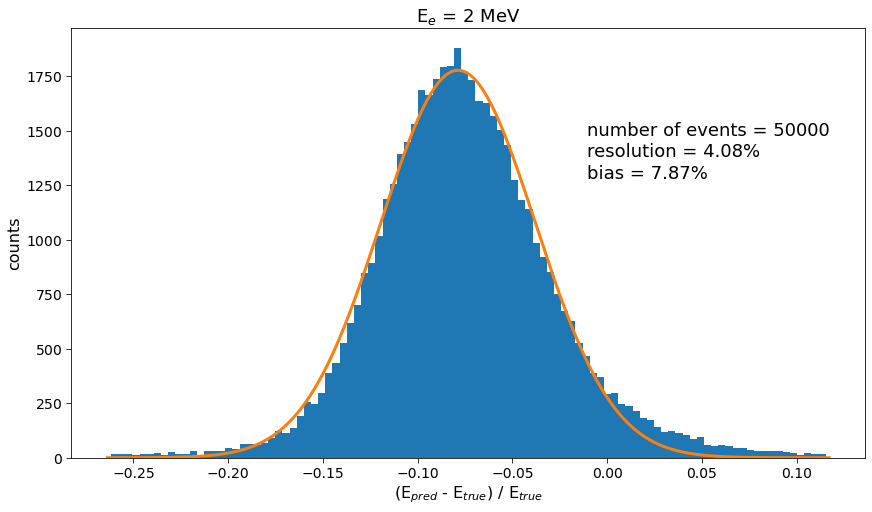

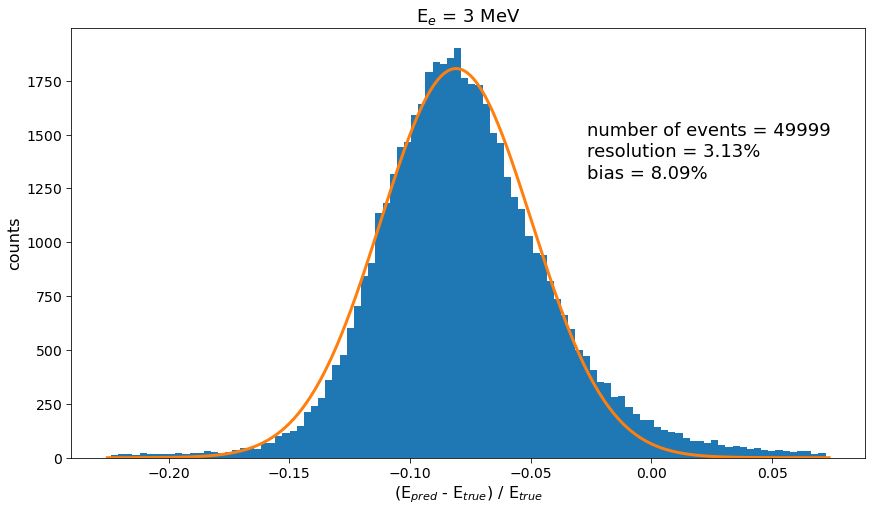

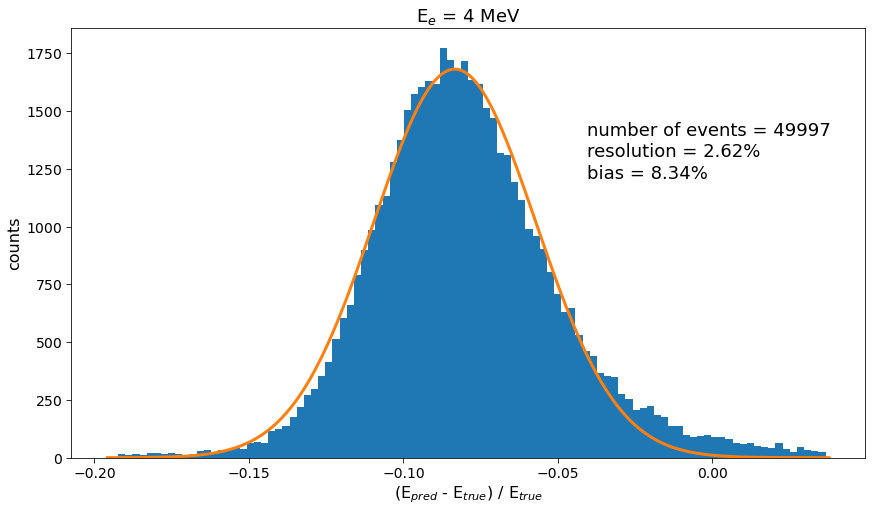

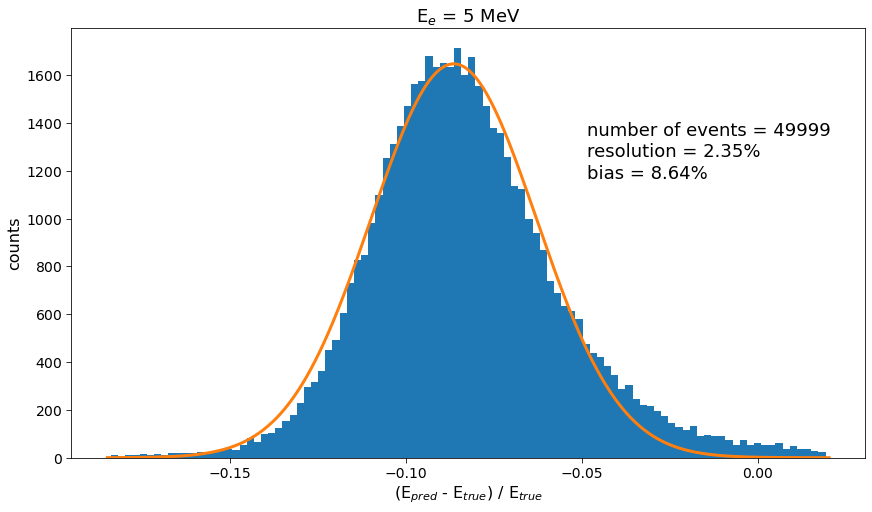

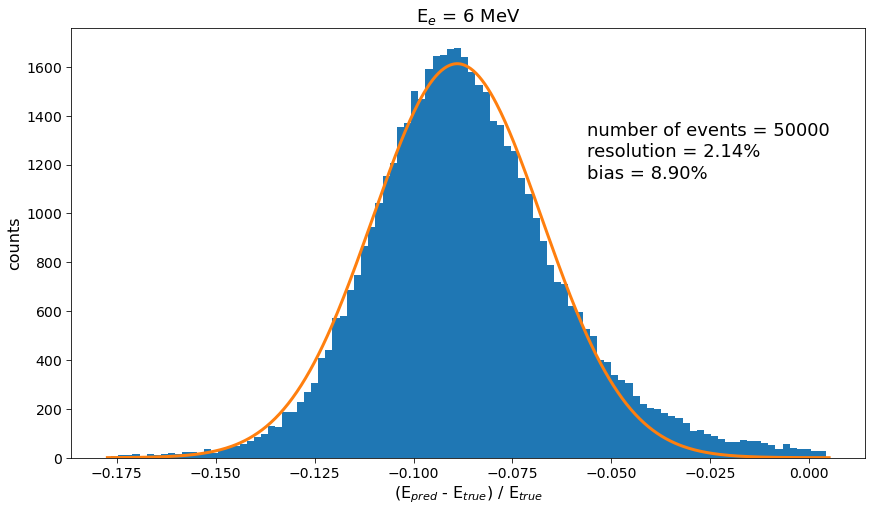

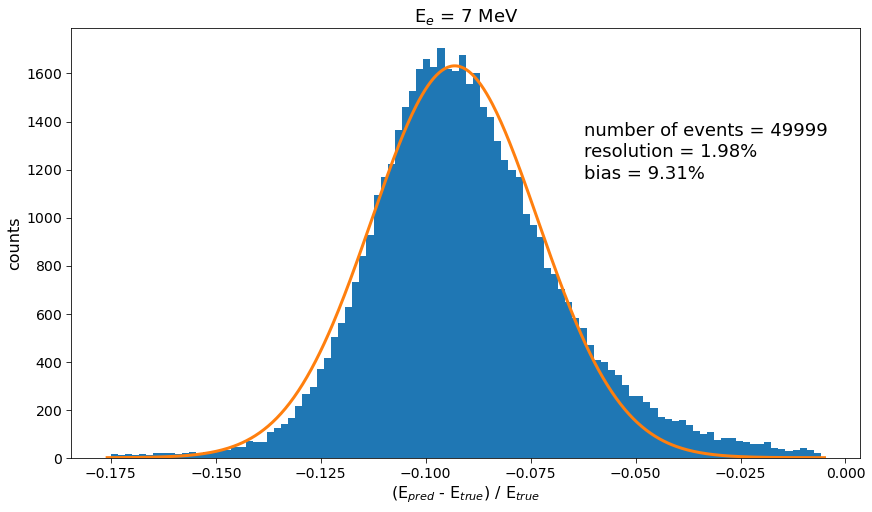

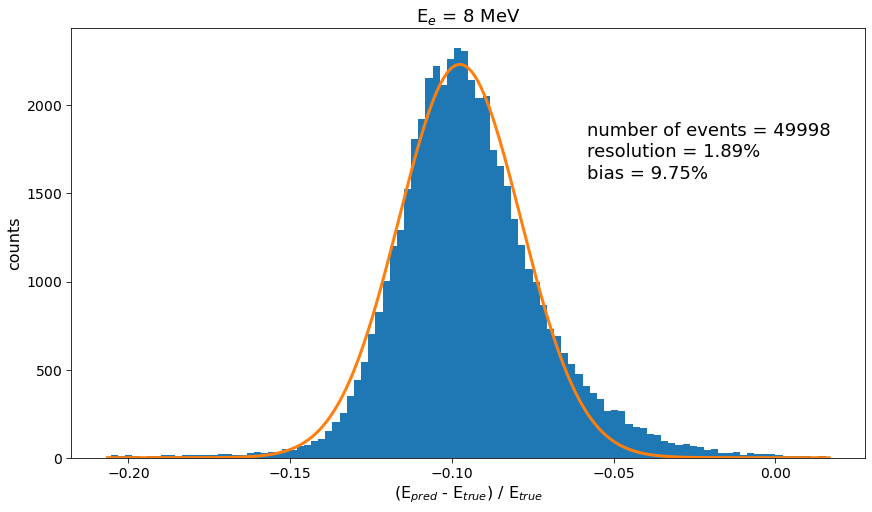

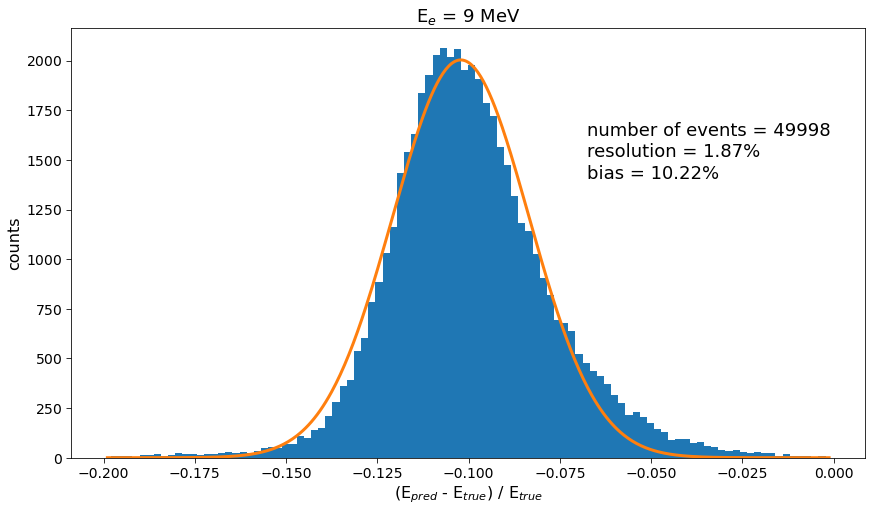

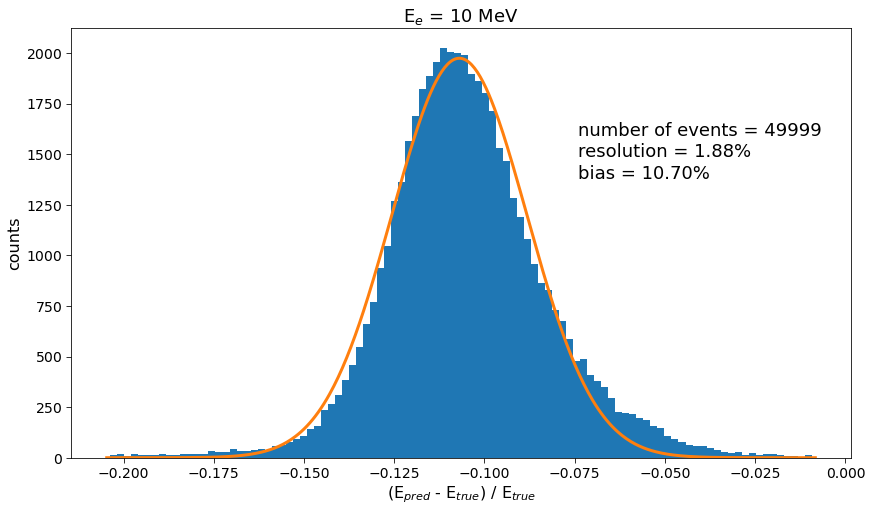

In [18]:
resolution_     = []
err_resolution_ = []
bias_           = []
err_bias_       = []

for e in energies:
    hist, edges = np.histogram(res[e], bins=100)
    bincenters = (edges[1:] + edges[:-1]) / 2

    xgrid = np.linspace(edges[0], edges[-1], 500)

    n     = res[e].shape[0]
    mean  = res[e].mean()
    sigma = res[e].std()
    popt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])

    n_events   = edep_pred[e].shape[0]
    resolution = popt[2]
    bias       = popt[1]

    resolution_.append(resolution)
    err_resolution_.append(np.sqrt(np.diag(pcov))[2])
    bias_.append(bias)
    err_bias_.append(np.sqrt(np.diag(pcov))[2])

    fig = plt.figure(figsize=(12,7), constrained_layout=True)
    ax  = fig.add_subplot(111)

    ax.hist(bincenters, weights=hist, bins=100)
    ax.plot(xgrid, gaus(xgrid, *popt), lw=3)
    ax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)
    ax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)
    ax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)

    ax.set_title(f"E$_e$ = {e} MeV", fontsize=18)
    ax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=16)
    ax.set_ylabel("counts", fontsize=16)


    # ax.set_yscale("log")

    ax.tick_params(axis="both", which="major", labelsize=14, length=5)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_offset_text().set_fontsize(14)

    fig.savefig(f"../images/cnn/e_{e}mev_hist_cnn.png", dpi=300, facecolor="white")


In [27]:
energy = [
    0, 
    0.1, 
    0.3, 
    0.6, 
    1, 
    2, 
    3, 
    4, 
    5, 
    6, 
    7, 
    8, 
    9, 
    10
]
results = pd.DataFrame(
    {
        "energy":         energy,
        "resolution":     resolution_,
        "err_resolution": err_resolution_,
        "bias":           np.abs(bias_),
        "err_bias":       err_bias_
    }
)
results

,energy,resolution,err_resolution,bias,err_bias
0,0.0,0.100833,0.000893,0.078275,0.000893
1,0.1,0.094672,0.000707,0.032926,0.000707
2,0.3,0.087569,0.000480,0.017742,0.000480
3,0.6,0.072045,0.000458,0.050686,0.000458
4,1.0,0.058548,0.000393,0.068593,0.000393
5,2.0,0.040771,0.000344,0.078713,0.000344
6,3.0,0.031319,0.000340,0.080895,0.000340
7,4.0,0.026224,0.000285,0.083372,0.000285
8,5.0,0.023528,0.000283,0.086388,0.000283
9,6.0,0.021425,0.000225,0.088958,0.000225


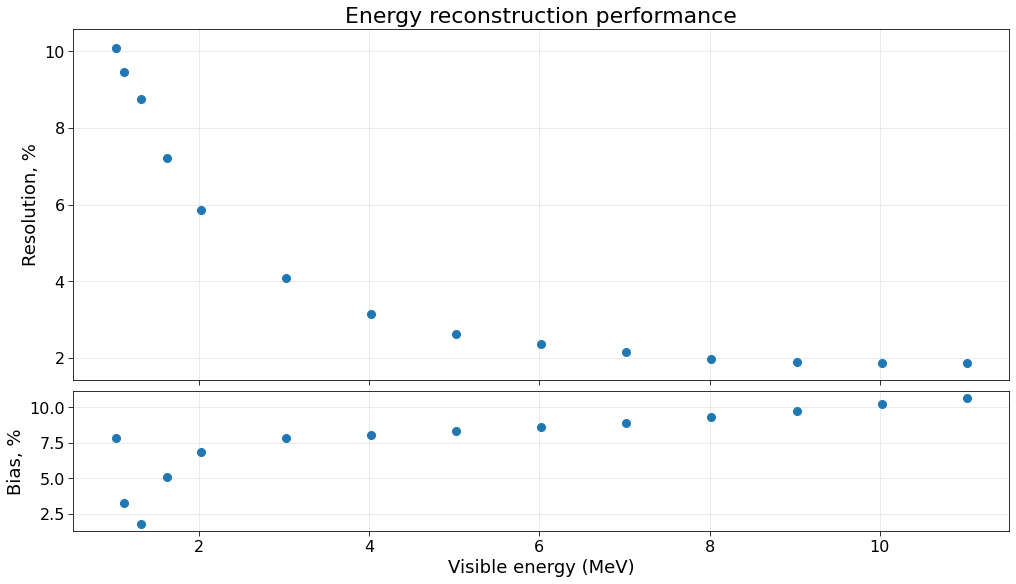

In [29]:
fig = plt.figure(figsize=(14,8), constrained_layout=True)

gs = fig.add_gridspec(2, 1, height_ratios=[5, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(color="k", alpha=0.1)
ax2.grid(color="k", alpha=0.1)

ax1.errorbar(
    results.energy + 1.022, 
    results.resolution * 100, 
    yerr=results.err_resolution * 100,
    marker="o",
    ls="none",
    #color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    markersize=8
)

ax2.errorbar(
    results.energy + 1.022, 
    results.bias * 100, 
    yerr=results.err_bias * 100,
    marker="o",
    ls="none",
    #color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    markersize=8
)

ax1.set_title(f"Energy reconstruction performance", fontsize=22)
ax1.set_ylabel("Resolution, %", fontsize=18)
ax2.set_xlabel("Visible energy (MeV)", fontsize=18)
ax2.set_ylabel("Bias, %", fontsize=18)
ax1.tick_params(axis="both", which="major", labelsize=16, length=5)
ax2.tick_params(axis="both", which="major", labelsize=16, length=5)
ax1.set_xticklabels([])

plt.show()

## Trainable Quanvolutional NN

### Anstaz 1

In [11]:
debug=False
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, strides=(1, 1), activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = (filter_size, filter_size) if type(filter_size)==int else filter_size
        self.pixels = self.filter_size[0]*self.filter_size[1]
        self.depth = depth
        self.strides = strides
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size[0]*self.depth, self.filter_size[1])      # a circuit for each depth
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(self.pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i%self.pixels])(qubit))                                 # input params repeats for each depth
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(self.pixels).astype(np.int32))]                                    # add for in depth
        
        if np.log2(self.pixels) % 1 == 0:
            for i in range(self.depth):
                skip = i*self.pixels
                for step in step_size:
                    for target in range(0, self.pixels, 2*step):
                        QCNN_circuit.append(self._QConv(step, target+skip, cirq_qubits))                        # split the circuits
        else:
            for i in range(self.depth):
                skip = i*self.pixels
                for target in range(self.pixels-1):
                    QCNN_circuit.append(self._QConv(1, target+skip, cirq_qubits))                               # split the circuits
                QCNN_circuit.append(self._QConv(1-self.pixels, self.pixels-1+skip, cirq_qubits))
                
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        
        self.params = input_params + self.learning_params
        self.op = [cirq.Z(cirq_qubits[(i+1)]) for i in range(0, len(cirq_qubits), self.pixels)]                      # measure
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = (self.width - self.filter_size[0]) // self.strides[0] + 1
        self.num_y = (self.height - self.filter_size[1]) // self.strides[1] + 1
        if(((self.width - self.filter_size[0]) % self.strides[0]) or 
           ((self.height - self.filter_size[1]) % self.strides[1])):
            if(((self.width - self.filter_size[0]) % self.strides[0]) and 
               ((self.height - self.filter_size[1]) % self.strides[1])):
                print("WARNING: cutting image borders, consider changing filter size or stride on both dimensions")    
            elif((self.height - self.filter_size[1]) % self.strides[1]):
                print("WARNING: cutting image borders, consider changing filter size or stride on dimension 1")
            else:
                print("WARNING: cutting image borders, consider changing filter size or stride along dimension 0")
                
        self.kernel = self.add_weight(name="kenel",                                                                     # careful with self.learning_params
                                      shape=[self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        if debug:
            print('circuit_tensor:', self.circuit_tensor.shape)
        

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(0, self.width-self.filter_size[0]+1, self.strides[0]):
            for j in range(0, self.height-self.filter_size[1]+1, self.strides[1]):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size[0], self.filter_size[1], -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size[0], self.filter_size[1], self.channel])
                if debug:
                    print('i, j:', i, j)
                    print('slice_part:', slice_part.shape)
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)
                del slice_part
        if debug:
            print('stack_set:', stack_set.shape) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size[0]*self.filter_size[1]])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        if debug:
            print(stack_set.shape, stack_set)
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        #tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        
        controller = tf.tile(self.kernel, [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs=self.single_depth_QCNN(stack_set, controller, circuit_inputs)
        # shape: [N, num_x, num_y, self.depth] 
        del stack_set
        del controller
        del circuit_inputs
            
        output_tensor = tf.math.acos(tf.clip_by_value(outputs, -1+1e-5, 1-1e-5)) / np.pi
        del outputs
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        del input_data
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel, self.depth])
        return tf.math.reduce_sum(QCNN_output, 3)

    @property
    def svg(self):
        circtoplot = self.circuit
        circtoplot.append(self.op)
        return SVGCircuit(circtoplot)

### Ansatz 2

In [ ]:
debug=False

class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, strides=(1, 1), activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = (filter_size, filter_size) if type(filter_size)==int else filter_size
        self.pixels = self.filter_size[0]*self.filter_size[1]
        self.depth = depth
        self.strides = strides
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        for qubit in qubits:
            yield cirq.YPowGate(exponent=self._get_new_param())(qubit)
        for i in range(1, len(qubits)):    
            for j in range(0, i):
                yield cirq.CNOT(qubits[j], qubits[i])
        for qubit in qubits:
            yield cirq.YPowGate(exponent=self._get_new_param())(qubit)

    def _Encoding(self, qubits, input_params):                   # pass the inputs already divided by depth
        for i, qubit in enumerate(qubits):
            yield cirq.H(qubit)
            yield cirq.ZPowGate(exponent=input_params[i])(qubit)
        for i in range(1, len(qubits)):    
            for j in range(0, i):
                yield cirq.CNOT(qubits[j], qubits[i])
                #mixed_rot = sympy.Mul(input_params[i]*input_params[j])
                #yield ((cirq.Z**input_params[i])**input_params[j])(qubits[i])
                yield cirq.ZPowGate(exponent=input_params[i*(i-1)//2 + j + len(qubits)])(qubits[i])
                yield cirq.CNOT(qubits[j], qubits[i])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size[0]*self.depth, self.filter_size[1])      # a circuit for each depth
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(self.pixels)] + \
                       [sympy.symbols(f'a{i}{j}') for i in range(1, self.pixels) for j in range(0, i)]              #all input parameters calculated outside circuit
        for i in range(self.depth):
            input_circuit.append(self._Encoding(cirq_qubits[i*self.pixels : (i+1)*self.pixels], input_params))                                 # input params repeats for each depth
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(self.pixels).astype(np.int32))]                                    # add for in depth
        
        for i in range(self.depth):
            QCNN_circuit.append(self._QConv(cirq_qubits[i*self.pixels : (i+1)*self.pixels]))
        '''
        if np.log2(self.pixels) % 1 == 0:
            for i in range(self.depth):
                skip = i*self.pixels
                for step in step_size:
                    for target in range(0, self.pixels, 2*step):
                        QCNN_circuit.append(self._QConv(step, target+skip, cirq_qubits))                        # split the circuits
        else:
            for i in range(self.depth):
                skip = i*self.pixels
                for target in range(self.pixels-1):
                    QCNN_circuit.append(self._QConv(1, target+skip, cirq_qubits))                               # split the circuits
                QCNN_circuit.append(self._QConv(1-self.pixels, self.pixels-1+skip, cirq_qubits))
        '''        
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = [cirq.Z(qubit) for qubit in cirq_qubits]                   # measure
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = (self.width - self.filter_size[0]) // self.strides[0] + 1
        self.num_y = (self.height - self.filter_size[1]) // self.strides[1] + 1
        if(((self.width - self.filter_size[0]) % self.strides[0]) or 
           ((self.height - self.filter_size[1]) % self.strides[1])):
            if(((self.width - self.filter_size[0]) % self.strides[0]) and 
               ((self.height - self.filter_size[1]) % self.strides[1])):
                print("WARNING: cutting image borders, consider changing filter size or stride on both dimensions")    
            elif((self.height - self.filter_size[1]) % self.strides[1]):
                print("WARNING: cutting image borders, consider changing filter size or stride on dimension 1")
            else:
                print("WARNING: cutting image borders, consider changing filter size or stride along dimension 0")
                
        self.kernel = self.add_weight(name="kenel",                                                                     # careful with self.learning_params
                                      shape=[self.channel, 
                                             len(self.learning_params)],
                                      initializer=tf.keras.initializers.glorot_normal(),
                                      regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(0, self.width-self.filter_size[0]+1, self.strides[0]):
            for j in range(0, self.height-self.filter_size[1]+1, self.strides[1]):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size[0], self.filter_size[1], -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size[0], self.filter_size[1], self.channel])
                if debug:
                    print('i, j:', i, j)
                    print('slice_part:', slice_part.shape)
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1) 
        if debug:
            print('stack_set:', stack_set.shape) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size[0]*self.filter_size[1]])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        feature_map_extension = tf.map_fn(lambda el: tf.stack([(np.pi-el[i])*(np.pi-el[j])                      # add second depth feature mapping
                                                               for i in range(1, self.pixels) 
                                                               for j in range(0, i)]), stack_set)
        if debug:
            print('other:', feature_map_extension.shape)
        stack_set = tf.concat([stack_set, feature_map_extension], 1)
        if debug:
            print(stack_set.shape)
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        #tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        #outputs = []
        
        controller = tf.tile(self.kernel, [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs=self.single_depth_QCNN(stack_set, controller, circuit_inputs)
        # shape: [N, num_x, num_y, self.depth] 
            
        output_tensor = outputs #tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel*self.depth*pixels]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel, self.depth, self.pixels])
        return tf.math.reduce_sum(tf.math.reduce_sum(QCNN_output, 5), 3)

    @property
    def svg(self):
        circtoplot = self.circuit
        circtoplot.append(self.op)
        return SVGCircuit(circtoplot)

In [12]:
import datetime

In [37]:
def hybrid_qcnn_model(
    img_size = (57, 31),
    channels = 2
):
    hybrid_qcnn_model = models.Sequential(
        [
            layers.Conv2D(
                filters     = 32, 
                kernel_size = 3, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            layers.Conv2D(
                filters     = 64, 
                kernel_size = 2, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            QConv(
                filter_size=2, 
                strides=(2,2), 
                depth=1, 
                activation='relu', 
                name='qconv'
            ),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='linear')
        ]
    )

    hybrid_qcnn_model.compile(
        optimizer='adam',
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return hybrid_qcnn_model

In [38]:
fig_shape = (train_images.shape[1], train_images.shape[2])
channels = 2

hybrid_qcnn = hybrid_qcnn_model(
    img_size = fig_shape,
    channels = channels
)

In [39]:
hybrid_qcnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 15, 32)        608       
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 7, 64)         8256      
                                                                 
 qconv (QConv)               (None, 7, 3, 1)           384       
                                                                 
 flatten_4 (Flatten)         (None, 21)                0         
                                                                 
 dense_12 (Dense)            (None, 512)               11264     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [ ]:
'''
log = False

width = np.shape(train_images)[1]
height = np.shape(train_images)[2]
channels = 2

qcnn_model = models.Sequential()


qcnn_model.add(layers.Conv2D(
                filters     = 32, 
                kernel_size = 2, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (width, height, channels),
                data_format = 'channels_last'
            ))
qcnn_model.add(layers.Conv2D(
                filters     = 2, 
                kernel_size = 64, 
                activation  = 'relu',
                strides     = (2,2), 
                data_format = 'channels_last'
            ))
#qcnn_model.add(QConv(filter_size=2, strides=(1,1), depth=2, activation='relu', 
#                     name='qconv'))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(512, activation='relu'))
qcnn_model.add(layers.Dropout(0.1))
qcnn_model.add(layers.Dense(128, activation='relu'))
qcnn_model.add(layers.Dense(1, activation='linear'))

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if log:
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)'''

In [ ]:
'''qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

qcnn_model.build(input_shape=(None, width, height, 2))
qcnn_model.summary()'''

In [40]:
n_epochs   = 10
batch_size = 64

hybrid_qcnn_history = hybrid_qcnn.fit(
    train_images[:50000],
    train_labels[:50000],
    validation_split = 0.1,
    batch_size       = batch_size,
    epochs           = n_epochs
)

Epoch 1/10
 16/704 [..............................] - ETA: 1:29:57 - loss: 44.0074 - root_mean_squared_error: 6.6338

KeyboardInterrupt: 